# 05_final_analysis.ipynb - Фінальний аналіз push-сповіщень

## 🎯 Фінальний аналіз впливу push-сповіщень на депозити Android-користувачів

Цей ноутбук завершує всі аналізи та надає остаточні рекомендації для оптимізації push-стратегії.

### 📊 Основні завдання:
1. **Географічний Tier-аналіз** - оптимальна кількість push-ів по регіонах
2. **Temporal аналіз** - коли відбуваються депозити
3. **Аналіз за застосунками** - ефективність TMNT груп
4. **Фінальні рекомендації** - actionable інсайти для бізнесу

### 🔧 Вхідні дані:
- **3,219,484 користувачів** (матчинг push + conversion)
- **41,193 користувачів з депозитами** (1.28% конверсія)
- **$226,815 загального доходу**

---

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu
import json
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Налаштування візуалізації
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print('🎯 ФІНАЛЬНИЙ АНАЛІЗ PUSH-СТРАТЕГІЇ')
print('=' * 55)
print('📊 Комплексний аналіз ефективності push-сповіщень')
print('🌍 Фокус: Географічна оптимізація та temporal patterns')
print('💡 Мета: Actionable рекомендації для бізнесу')

🎯 ФІНАЛЬНИЙ АНАЛІЗ PUSH-СТРАТЕГІЇ
📊 Комплексний аналіз ефективності push-сповіщень
🌍 Фокус: Географічна оптимізація та temporal patterns
💡 Мета: Actionable рекомендації для бізнесу


## **КРОК 1: Завантаження та підготовка даних**

In [9]:
print('\n🔗 КРОК 1: ЗАВАНТАЖЕННЯ ФІНАЛЬНИХ ДАНИХ')
print('-' * 45)

# Завантажуємо готові дані з матчингу
try:
    df = pd.read_parquet('../data/processed/ab_analysis_ready.parquet')
    print(f'✅ Основний датасет завантажено: {len(df):,} записів')
except FileNotFoundError:
    print('❌ Файл ab_analysis_ready.parquet не знайдено. Завантажуємо з матчингу...')
    # Fallback - завантажуємо окремі файли та робимо матчинг
    push_df = pd.read_parquet('../data/processed/push_users_data.parquet')
    conv_df = pd.read_parquet('../data/processed/conversion_users_data.parquet')
    
    # Швидкий матчинг
    df = push_df.merge(conv_df, on='gadid', how='left', suffixes=('_push', '_conv'))
    
    # Додаємо бінарні індикатори
    df['has_deposit'] = (df['total_deposits'].fillna(0) > 0).astype(int)
    df['has_registration'] = (df['total_registrations'].fillna(0) > 0).astype(int)
    df['total_revenue'] = df['total_revenue'].fillna(0)
    
    # Фінальні колонки
    df['tier_final'] = df['tier_push'].fillna(df['tier_conv']) if 'tier_conv' in df.columns else df.get('tier')
    df['country_final'] = df['country_push'].fillna(df['country_conv']) if 'country_conv' in df.columns else df.get('country')
    
    print(f'✅ Матчинг виконано: {len(df):,} записів')

# Додаємо інформацію про TMNT групи застосунків
print('\n📱 ЗАВАНТАЖЕННЯ TMNT ГРУП ЗАСТОСУНКІВ:')
try:
    tmnt_df = pd.read_parquet('../data/processed/matched_push_conversions.parquet')
    print(f'✅ TMNT датасет завантажено: {len(tmnt_df):,} записів')
    print(f'📊 TMNT колонки: {list(tmnt_df.columns)}')
    
    # Перевіряємо наявність ключових колонок
    if 'group_name' in tmnt_df.columns:
        tmnt_groups = tmnt_df['group_name'].value_counts()
        print(f'🎭 TMNT групи: {tmnt_groups.to_dict()}')
        
        # Вибираємо необхідні колонки для merge
        tmnt_cols = ['gadid', 'group_name']
        
        # Додаємо додаткові корисні колонки якщо є
        extra_cols = ['user_category', 'push_segment', 'revenue_per_push', 'conversion_window_days']
        for col in extra_cols:
            if col in tmnt_df.columns:
                tmnt_cols.append(col)
        
        tmnt_subset = tmnt_df[tmnt_cols].drop_duplicates('gadid')
        print(f'📋 Колонки для merge: {tmnt_cols}')
        
        # Merge з основним датасетом
        df_before = len(df)
        df = df.merge(tmnt_subset, on='gadid', how='left')
        print(f'✅ TMNT merge виконано: {df_before:,} → {len(df):,} записів')
        
        # Перевіряємо успішність merge
        tmnt_matched = df['group_name'].notna().sum()
        print(f'🎯 Користувачів з TMNT інфо: {tmnt_matched:,} ({tmnt_matched/len(df)*100:.1f}%)')
        
        if tmnt_matched > 0:
            tmnt_final_groups = df['group_name'].value_counts()
            print(f'🎭 Фінальний розподіл TMNT груп: {tmnt_final_groups.to_dict()}')
    else:
        print('⚠️ Колонка group_name не знайдена в TMNT датасеті')
        
except FileNotFoundError:
    print('❌ Файл matched_push_conversion.parquet не знайдено')
    print('💡 Продовжуємо без TMNT інформації')

# Швидка перевірка якості даних
print('\n📊 ЯКІСТЬ ФІНАЛЬНИХ ДАНИХ:')
print(f'   📱 Унікальних gadid: {df["gadid"].nunique():,}')
print(f'   💰 З депозитами: {df["has_deposit"].sum():,} ({df["has_deposit"].mean()*100:.2f}%)')
print(f'   📝 З реєстраціями: {df["has_registration"].sum():,} ({df["has_registration"].mean()*100:.2f}%)')
print(f'   💵 Загальний дохід: ${df["total_revenue"].sum():,.2f}')
print(f'   🏷️ A/B групи: {sorted(df["ab_group"].unique())}')

# Перевірка Tier розподілу
tier_col = 'tier_final' if 'tier_final' in df.columns else 'tier'
if tier_col in df.columns:
    tier_dist = df[tier_col].value_counts()
    print(f'   🌍 Tier розподіл: {tier_dist.to_dict()}')
else:
    print('   ⚠️ Колонка tier не знайдена, створюємо базову класифікацію')

# Перевірка TMNT груп
if 'group_name' in df.columns:
    print(f'   🎭 TMNT групи в фінальному датасеті: {df["group_name"].value_counts().to_dict()}')

print('\n✅ Дані готові для фінального аналізу!')
print(f'📋 Фінальні колонки: {list(df.columns)}')


🔗 КРОК 1: ЗАВАНТАЖЕННЯ ФІНАЛЬНИХ ДАНИХ
---------------------------------------------
✅ Основний датасет завантажено: 3,219,484 записів

📱 ЗАВАНТАЖЕННЯ TMNT ГРУП ЗАСТОСУНКІВ:
✅ TMNT датасет завантажено: 3,219,484 записів
📊 TMNT колонки: ['gadid', 'ab_group', 'country_push', 'total_pushes', 'successful_pushes', 'success_rate', 'first_push', 'last_push', 'active_days', 'tier_push', 'campaign_duration_hours', 'pushes_per_day', 'country_conv', 'campaign_id', 'group_id', 'group_name', 'total_deposits', 'total_registrations', 'total_revenue', 'lead_revenue', 'total_events', 'first_conversion_date', 'last_conversion_date', 'first_conversion_datetime', 'last_conversion_datetime', 'conversion_days', 'conversion_type', 'tier_conv', 'conversion_window_days', 'avg_revenue_per_conversion', 'arpu', 'has_deposit', 'has_registration', 'has_conversion', 'country_final', 'tier_final', 'revenue_per_push', 'user_category', 'push_segment']
🎭 TMNT групи: {'Splinter (Oleksandr)': 88016, 'Zhenya (Leonardo)': 

## **КРОК 2: 🌍 ГЕОГРАФІЧНИЙ TIER-АНАЛІЗ**

### **2.1 Базовий розподіл по Tier-ах**


🌍 КРОК 2.1: БАЗОВИЙ РОЗПОДІЛ ПО TIER-АХ
---------------------------------------------
📊 МЕТРИКИ ПО TIER-АХ:


,users,users_pct,avg_pushes,deposit_rate_pct,arpu
tier_final,,,,,
Other,317990,9.88,84.0907,4.58,0.1173
Tier 1,146671,4.56,195.8796,2.42,0.6321
Tier 2,692620,21.51,104.8555,2.42,0.1100
Tier 3,311368,9.67,115.2713,1.50,0.0070
Unknown,1750835,54.38,113.0961,0.09,0.0105


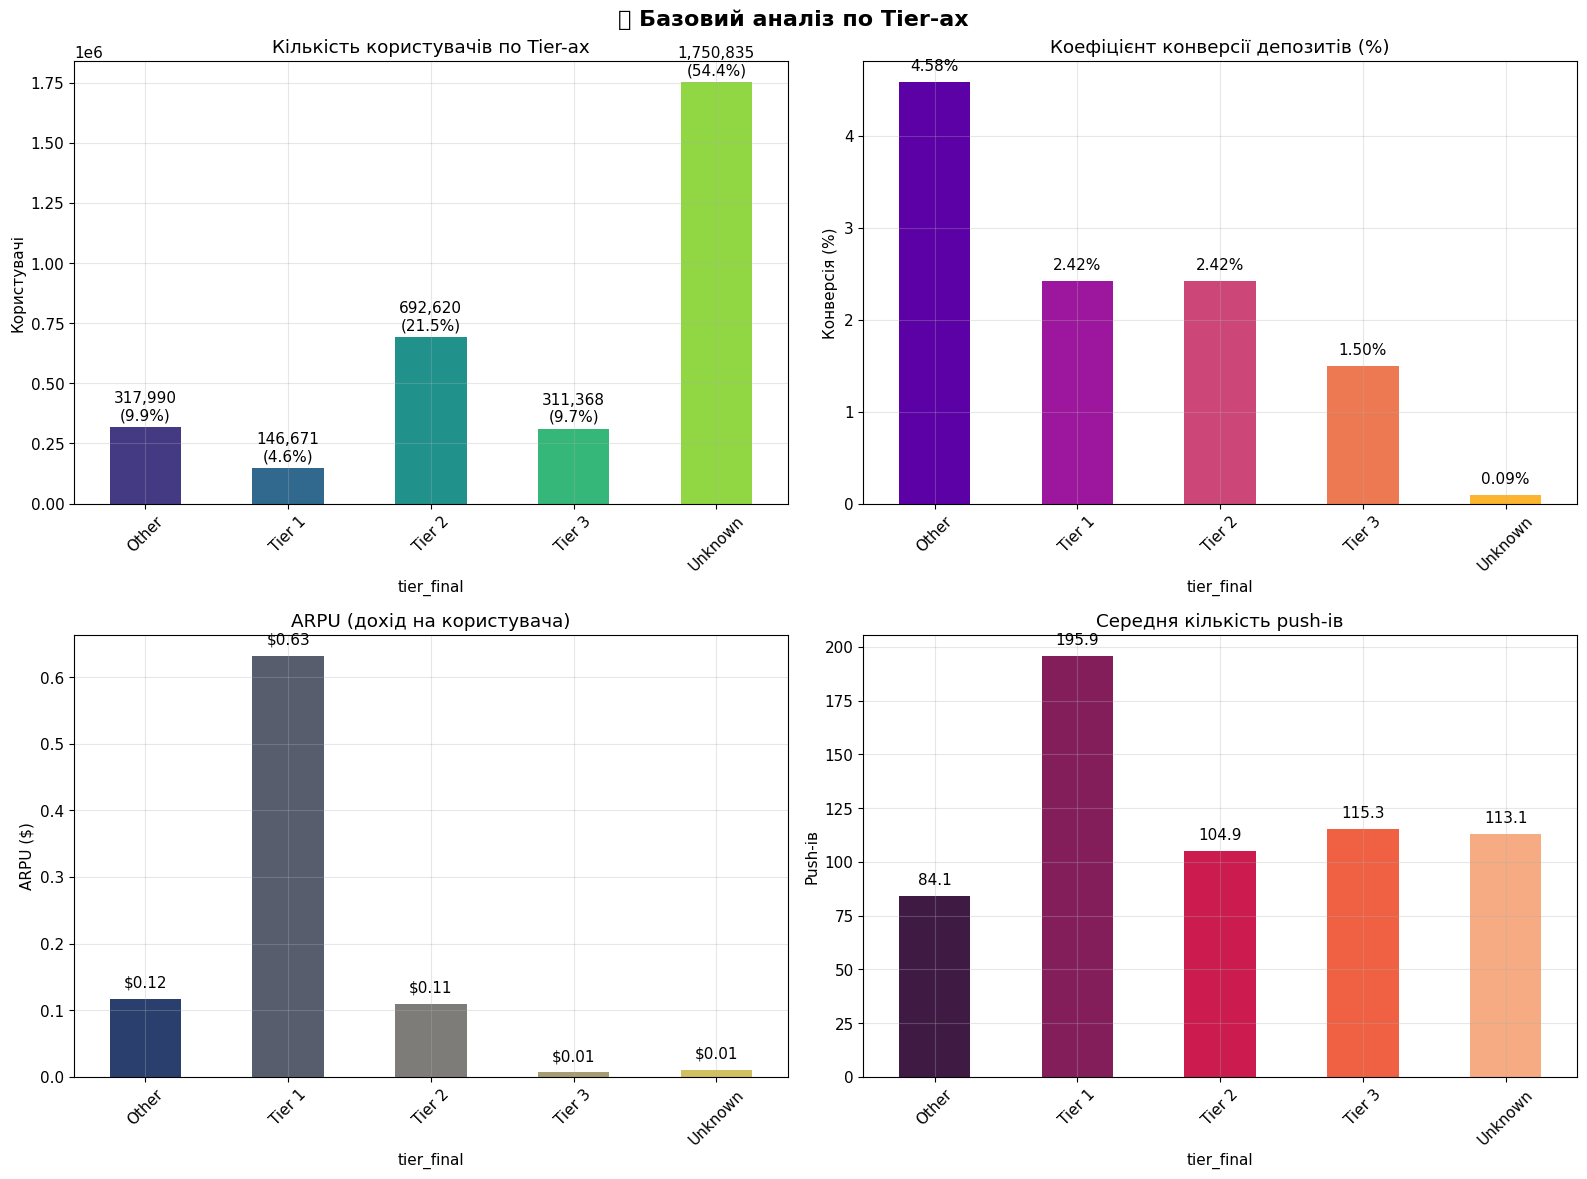


🎯 КЛЮЧОВІ ІНСАЙТИ ПО TIER-АХ:
   🏆 Найкраща конверсія: Other (4.58%)
   💰 Найкращий ARPU: Tier 1 ($0.63)
   👥 Найбільший сегмент: Unknown (54.4% користувачів)


In [3]:
print('\n🌍 КРОК 2.1: БАЗОВИЙ РОЗПОДІЛ ПО TIER-АХ')
print('-' * 45)

# Визначаємо колонку tier
tier_col = 'tier_final' if 'tier_final' in df.columns else ('tier' if 'tier' in df.columns else None)

if tier_col is None:
    print('⚠️ Створюємо tier на основі country')
    # Базова tier класифікація
    tier_1_countries = ['US', 'CA', 'GB', 'AU', 'DE', 'SE', 'NO', 'DK', 'CH', 'AT']
    tier_2_countries = ['FR', 'IT', 'ES', 'PT', 'BE', 'NL', 'FI', 'IE', 'NZ', 'IL', 'SG', 'HK', 'JP', 'KR']
    
    country_col = 'country_final' if 'country_final' in df.columns else 'country'
    
    def assign_tier(country):
        if pd.isna(country) or country == 'Unknown':
            return 'Unknown'
        elif country in tier_1_countries:
            return 'Tier 1'
        elif country in tier_2_countries:
            return 'Tier 2'
        else:
            return 'Tier 3'
    
    df[tier_col] = df[country_col].apply(assign_tier)
    tier_col = 'tier'

# Розрахунок базових метрик по tier-ах
tier_stats = df.groupby(tier_col).agg({
    'gadid': 'count',
    'total_pushes': 'mean', 
    'has_deposit': ['sum', 'mean'],
    'has_registration': ['sum', 'mean'],
    'total_revenue': ['sum', 'mean']
}).round(4)

# Плоска структура колонок
tier_stats.columns = ['users', 'avg_pushes', 'deposits_count', 'deposit_rate', 
                     'registrations_count', 'registration_rate', 'total_revenue', 'arpu']

# Додаємо відсотки
tier_stats['users_pct'] = (tier_stats['users'] / tier_stats['users'].sum() * 100).round(2)
tier_stats['deposit_rate_pct'] = (tier_stats['deposit_rate'] * 100).round(2)
tier_stats['registration_rate_pct'] = (tier_stats['registration_rate'] * 100).round(2)

print('📊 МЕТРИКИ ПО TIER-АХ:')
display(tier_stats[['users', 'users_pct', 'avg_pushes', 'deposit_rate_pct', 'arpu']])

# Візуалізації
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 Базовий аналіз по Tier-ах', fontsize=16, fontweight='bold')

# 1. Розподіл користувачів
ax1 = axes[0, 0]
tier_stats['users'].plot(kind='bar', ax=ax1, color=sns.color_palette("viridis", len(tier_stats)))
ax1.set_title('Кількість користувачів по Tier-ах')
ax1.set_ylabel('Користувачі')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Додаємо значення на стовпці
for i, v in enumerate(tier_stats['users']):
    pct_val = tier_stats.iloc[i]['users_pct']
    ax1.text(i, v + max(tier_stats['users'])*0.01, f'{v:,.0f}\n({pct_val:.1f}%)', 
             ha='center', va='bottom')

# 2. Конверсія депозитів
ax2 = axes[0, 1]
tier_stats['deposit_rate_pct'].plot(kind='bar', ax=ax2, color=sns.color_palette("plasma", len(tier_stats)))
ax2.set_title('Коефіцієнт конверсії депозитів (%)')
ax2.set_ylabel('Конверсія (%)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

for i, v in enumerate(tier_stats['deposit_rate_pct']):
    ax2.text(i, v + max(tier_stats['deposit_rate_pct'])*0.02, f'{v:.2f}%', 
             ha='center', va='bottom')

# 3. ARPU
ax3 = axes[1, 0]
tier_stats['arpu'].plot(kind='bar', ax=ax3, color=sns.color_palette("cividis", len(tier_stats)))
ax3.set_title('ARPU (дохід на користувача)')
ax3.set_ylabel('ARPU ($)')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

for i, v in enumerate(tier_stats['arpu']):
    ax3.text(i, v + max(tier_stats['arpu'])*0.02, f'${v:.2f}', 
             ha='center', va='bottom')

# 4. Середня кількість push-ів
ax4 = axes[1, 1]
tier_stats['avg_pushes'].plot(kind='bar', ax=ax4, color=sns.color_palette("rocket", len(tier_stats)))
ax4.set_title('Середня кількість push-ів')
ax4.set_ylabel('Push-ів')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

for i, v in enumerate(tier_stats['avg_pushes']):
    ax4.text(i, v + max(tier_stats['avg_pushes'])*0.02, f'{v:.1f}', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Ключові інсайти
best_conversion_tier = tier_stats['deposit_rate_pct'].idxmax()
best_arpu_tier = tier_stats['arpu'].idxmax()
largest_tier = tier_stats['users'].idxmax()

print('\n🎯 КЛЮЧОВІ ІНСАЙТИ ПО TIER-АХ:')
print(f'   🏆 Найкраща конверсія: {best_conversion_tier} ({tier_stats.loc[best_conversion_tier, "deposit_rate_pct"]:.2f}%)')
print(f'   💰 Найкращий ARPU: {best_arpu_tier} (${tier_stats.loc[best_arpu_tier, "arpu"]:.2f})')
print(f'   👥 Найбільший сегмент: {largest_tier} ({tier_stats.loc[largest_tier, "users_pct"]:.1f}% користувачів)')

### **2.2 Оптимальна кількість push-ів до першого депозиту**


📱 КРОК 2.2: ОПТИМАЛЬНА КІЛЬКІСТЬ PUSH-ІВ
---------------------------------------------
📊 КОНВЕРСІЯ ПО ДІАПАЗОНАХ PUSH-ІВ ТА TIER-АХ:


tier_final,Other,Tier 1,Tier 2,Tier 3,Unknown
push_range,,,,,
1-10,2.43,1.29,3.49,1.21,0.06
11-20,2.64,0.89,2.61,0.92,0.07
21-30,1.89,0.43,1.26,0.37,0.07
31-50,2.71,0.29,0.71,0.55,0.08
51-100,20.31,1.04,4.74,12.17,0.66
100+,23.99,23.81,23.40,25.79,15.85


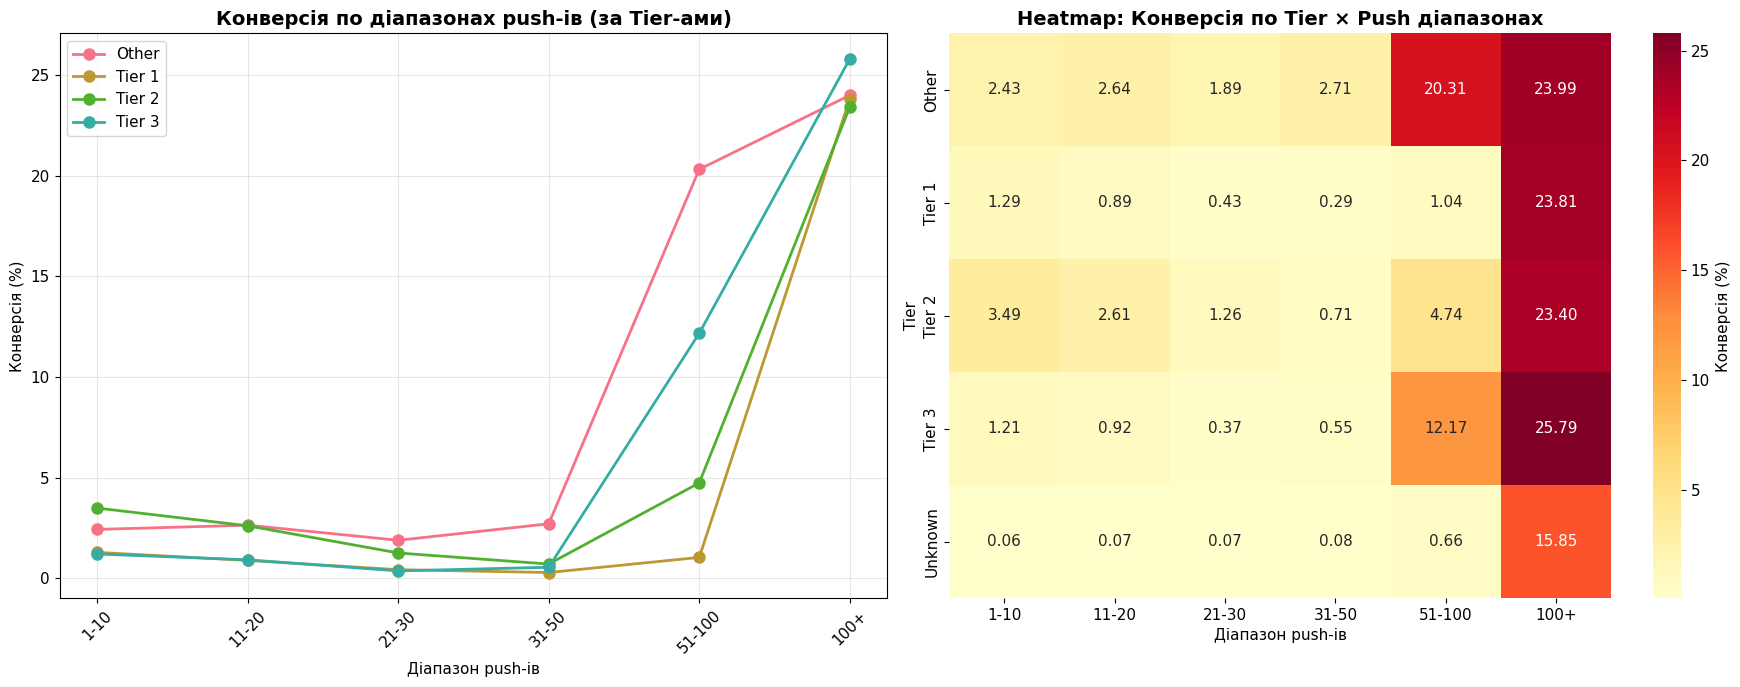


🎯 ОПТИМАЛЬНІ ДІАПАЗОНИ PUSH-ІВ ПО TIER-АХ:
   🏆 Other: 100+ push-ів → 23.99% конверсія (23,075 користувачів)
   🏆 Tier 1: 100+ push-ів → 23.81% конверсія (10,587 користувачів)
   🏆 Tier 2: 100+ push-ів → 23.40% конверсія (9,546 користувачів)
   🏆 Tier 3: 100+ push-ів → 25.79% конверсія (8,091 користувачів)

💰 ДОХІД НА КОРИСТУВАЧА ПО ДІАПАЗОНАХ:


tier_final,Other,Tier 1,Tier 2,Tier 3,Unknown
push_range,,,,,
1-10,0.22,1.02,0.17,0.01,0.01
11-20,0.15,0.86,0.13,0.01,0.01
21-30,0.09,0.48,0.07,0.00,0.01
31-50,0.04,0.30,0.05,0.00,0.01
51-100,0.07,0.34,0.20,0.01,0.06
100+,0.02,0.00,0.00,0.00,0.17


In [4]:
print('\n📱 КРОК 2.2: ОПТИМАЛЬНА КІЛЬКІСТЬ PUSH-ІВ')
print('-' * 45)

# Створюємо діапазони push-ів
df['push_range'] = pd.cut(df['total_pushes'], 
                         bins=[0, 10, 20, 30, 50, 100, float('inf')],
                         labels=['1-10', '11-20', '21-30', '31-50', '51-100', '100+'])

# Аналіз по tier-ах та діапазонах push-ів
push_tier_analysis = df.groupby([tier_col, 'push_range']).agg({
    'gadid': 'count',
    'has_deposit': ['sum', 'mean'],
    'total_revenue': 'sum'
}).round(4)

push_tier_analysis.columns = ['users', 'deposits', 'conversion_rate', 'revenue']
push_tier_analysis['conversion_pct'] = (push_tier_analysis['conversion_rate'] * 100).round(2)
push_tier_analysis['revenue_per_user'] = (push_tier_analysis['revenue'] / push_tier_analysis['users']).round(2)

# Фільтруємо групи з мінімальною кількістю користувачів
push_tier_analysis_filtered = push_tier_analysis[push_tier_analysis['users'] >= 100]

print('📊 КОНВЕРСІЯ ПО ДІАПАЗОНАХ PUSH-ІВ ТА TIER-АХ:')
pivot_conversion = push_tier_analysis_filtered['conversion_pct'].unstack(level=0, fill_value=0)
display(pivot_conversion)

# Візуалізація - Line plot конверсії по діапазонах
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Лінійний графік конверсії
ax1 = axes[0]
for tier in pivot_conversion.columns:
    if tier != 'Unknown':  # Виключаємо Unknown для чіткості
        ax1.plot(pivot_conversion.index, pivot_conversion[tier], 
                marker='o', linewidth=2, label=tier, markersize=8)

ax1.set_title('Конверсія по діапазонах push-ів (за Tier-ами)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Діапазон push-ів')
ax1.set_ylabel('Конверсія (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Heatmap конверсії
ax2 = axes[1]
sns.heatmap(pivot_conversion.T, annot=True, fmt='.2f', cmap='YlOrRd', 
           ax=ax2, cbar_kws={'label': 'Конверсія (%)'})
ax2.set_title('Heatmap: Конверсія по Tier × Push діапазонах', fontsize=14, fontweight='bold')
ax2.set_xlabel('Діапазон push-ів')
ax2.set_ylabel('Tier')

plt.tight_layout()
plt.show()

# Знаходимо оптимальні діапазони для кожного tier
print('\n🎯 ОПТИМАЛЬНІ ДІАПАЗОНИ PUSH-ІВ ПО TIER-АХ:')
optimal_ranges = {}

for tier in pivot_conversion.columns:
    if tier != 'Unknown' and not pivot_conversion[tier].empty:
        # Знаходимо діапазон з найкращою конверсією
        best_range = pivot_conversion[tier].idxmax()
        best_conversion = pivot_conversion[tier].max()
        
        # Також дивимося на кількість користувачів в цьому діапазоні
        users_in_range = push_tier_analysis_filtered.loc[(tier, best_range), 'users']
        
        optimal_ranges[tier] = {
            'range': best_range,
            'conversion': best_conversion,
            'users': users_in_range
        }
        
        print(f'   🏆 {tier}: {best_range} push-ів → {best_conversion:.2f}% конверсія ({users_in_range:,} користувачів)')

# Аналіз revenue per user по діапазонах
print('\n💰 ДОХІД НА КОРИСТУВАЧА ПО ДІАПАЗОНАХ:')
pivot_revenue = push_tier_analysis_filtered['revenue_per_user'].unstack(level=0, fill_value=0)
display(pivot_revenue.round(2))

# Збереження результатів для фінального звіту
optimal_push_results = {
    'optimal_ranges_by_tier': optimal_ranges,
    'conversion_by_range_tier': pivot_conversion.to_dict(),
    'revenue_by_range_tier': pivot_revenue.to_dict()
}

### **2.3 Temporal аналіз та Heatmap Tier × A/B група**


⏰ КРОК 2.3: TEMPORAL АНАЛІЗ ТА A/B × TIER
---------------------------------------------
ℹ️ Temporal аналіз недоступний - відсутні колонки з датами

🔥 HEATMAP: TIER × A/B ГРУПА (КОНВЕРСІЯ)


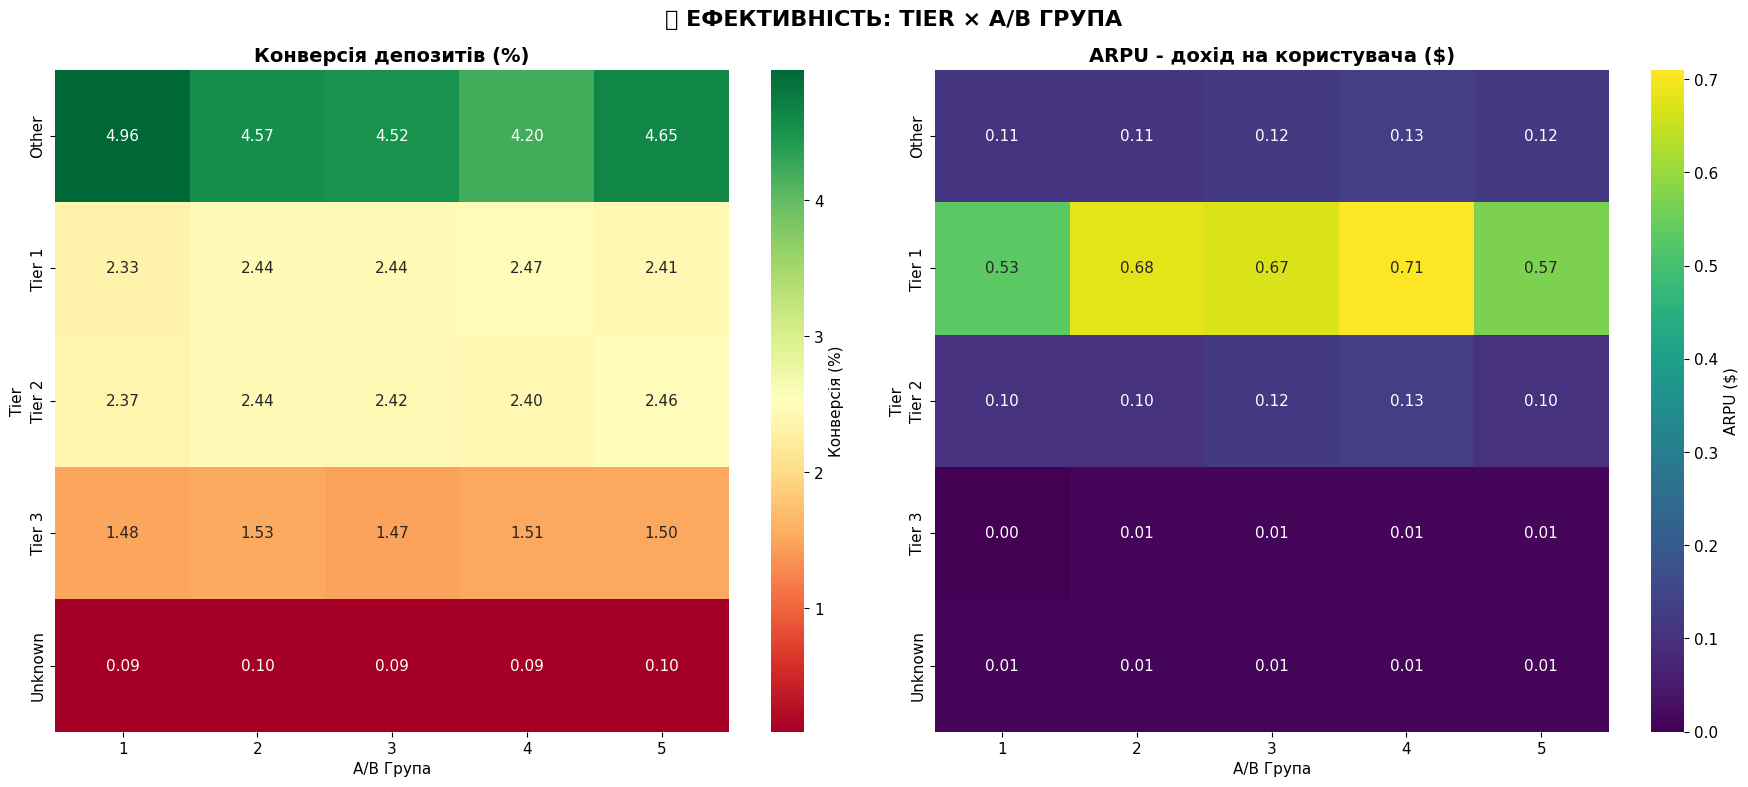


🏆 НАЙКРАЩІ КОМБІНАЦІЇ TIER × A/B ГРУПА:
   🎯 Other: A/B група 1 → 4.96% конверсія, $0.11 ARPU (64,344 користувачів)
   🎯 Tier 1: A/B група 4 → 2.47% конверсія, $0.71 ARPU (29,552 користувачів)
   🎯 Tier 2: A/B група 5 → 2.46% конверсія, $0.10 ARPU (139,127 користувачів)
   🎯 Tier 3: A/B група 2 → 1.53% конверсія, $0.01 ARPU (62,343 користувачів)


In [5]:
print('\n⏰ КРОК 2.3: TEMPORAL АНАЛІЗ ТА A/B × TIER')
print('-' * 45)

# Temporal аналіз - якщо є дати
temporal_analysis = {}

if 'first_push' in df.columns and 'first_conversion_datetime' in df.columns:
    # Обчислюємо час до першого депозиту
    depositors = df[df['has_deposit'] == 1].copy()
    
    if not depositors.empty:
        depositors['first_push'] = pd.to_datetime(depositors['first_push'])
        depositors['first_conversion_datetime'] = pd.to_datetime(depositors['first_conversion_datetime'])
        
        depositors['days_to_deposit'] = (depositors['first_conversion_datetime'] - 
                                       depositors['first_push']).dt.days
        
        # Temporal аналіз по tier-ах
        temporal_by_tier = depositors.groupby(tier_col)['days_to_deposit'].agg([
            'mean', 'median', 'std', 'min', 'max'
        ]).round(2)
        
        print('⏱️ ЧАСОВИЙ АНАЛІЗ ДО ПЕРШОГО ДЕПОЗИТУ:')
        display(temporal_by_tier)
        
        # Графік розподілу днів до депозиту
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Гістограма днів до депозиту
        ax1 = axes[0]
        depositors['days_to_deposit'].hist(bins=30, ax=ax1, alpha=0.7, edgecolor='black')
        ax1.set_title('Розподіл днів до першого депозиту')
        ax1.set_xlabel('Дні до депозиту')
        ax1.set_ylabel('Частота')
        ax1.grid(True, alpha=0.3)
        
        # Box plot по tier-ах
        ax2 = axes[1]
        depositors.boxplot(column='days_to_deposit', by=tier_col, ax=ax2)
        ax2.set_title('Дні до депозиту по Tier-ах')
        ax2.set_xlabel('Tier')
        ax2.set_ylabel('Дні до депозиту')
        
        plt.tight_layout()
        plt.show()
        
        temporal_analysis = {
            'avg_days_to_deposit_by_tier': temporal_by_tier['mean'].to_dict(),
            'median_days_to_deposit_by_tier': temporal_by_tier['median'].to_dict()
        }
        
        print('\n⚡ TEMPORAL ІНСАЙТИ:')
        fastest_tier = temporal_by_tier['median'].idxmin()
        fastest_days = temporal_by_tier.loc[fastest_tier, 'median']
        print(f'   🏃 Найшвидші депозити: {fastest_tier} ({fastest_days:.1f} днів медіана)')
else:
    print('ℹ️ Temporal аналіз недоступний - відсутні колонки з датами')

# ГОЛОВНИЙ HEATMAP: Tier × A/B група (конверсія)
print('\n🔥 HEATMAP: TIER × A/B ГРУПА (КОНВЕРСІЯ)')

tier_ab_analysis = df.groupby([tier_col, 'ab_group']).agg({
    'gadid': 'count',
    'has_deposit': ['sum', 'mean'],
    'total_revenue': 'sum'
}).round(4)

tier_ab_analysis.columns = ['users', 'deposits', 'conversion_rate', 'revenue']
tier_ab_analysis['conversion_pct'] = (tier_ab_analysis['conversion_rate'] * 100).round(2)
tier_ab_analysis['arpu'] = (tier_ab_analysis['revenue'] / tier_ab_analysis['users']).round(2)

# Фільтруємо групи з мінімальною кількістю користувачів
tier_ab_filtered = tier_ab_analysis[tier_ab_analysis['users'] >= 50]

# Створюємо pivot таблиці для heatmap
conversion_heatmap = tier_ab_filtered['conversion_pct'].unstack(level=1, fill_value=0)
arpu_heatmap = tier_ab_filtered['arpu'].unstack(level=1, fill_value=0)

# Головний Heatmap
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('🔥 ЕФЕКТИВНІСТЬ: TIER × A/B ГРУПА', fontsize=16, fontweight='bold')

# Heatmap конверсії
ax1 = axes[0]
sns.heatmap(conversion_heatmap, annot=True, fmt='.2f', cmap='RdYlGn', 
           ax=ax1, cbar_kws={'label': 'Конверсія (%)'})
ax1.set_title('Конверсія депозитів (%)', fontsize=14, fontweight='bold')
ax1.set_xlabel('A/B Група')
ax1.set_ylabel('Tier')

# Heatmap ARPU
ax2 = axes[1]
sns.heatmap(arpu_heatmap, annot=True, fmt='.2f', cmap='viridis', 
           ax=ax2, cbar_kws={'label': 'ARPU ($)'})
ax2.set_title('ARPU - дохід на користувача ($)', fontsize=14, fontweight='bold')
ax2.set_xlabel('A/B Група')
ax2.set_ylabel('Tier')

plt.tight_layout()
plt.show()

# Знаходимо найкращі комбінації Tier × A/B
print('\n🏆 НАЙКРАЩІ КОМБІНАЦІЇ TIER × A/B ГРУПА:')

best_combinations = {}
for tier in conversion_heatmap.index:
    if tier != 'Unknown':
        best_ab = conversion_heatmap.loc[tier].idxmax()
        best_conversion = conversion_heatmap.loc[tier].max()
        best_arpu = arpu_heatmap.loc[tier, best_ab]
        
        # Кількість користувачів в цій комбінації
        users_count = tier_ab_filtered.loc[(tier, best_ab), 'users']
        
        best_combinations[tier] = {
            'ab_group': best_ab,
            'conversion': best_conversion,
            'arpu': best_arpu,
            'users': users_count
        }
        
        print(f'   🎯 {tier}: A/B група {best_ab} → {best_conversion:.2f}% конверсія, ${best_arpu:.2f} ARPU ({users_count:,} користувачів)')

# Збереження результатів
tier_ab_results = {
    'best_combinations': best_combinations,
    'conversion_heatmap': conversion_heatmap.to_dict(),
    'arpu_heatmap': arpu_heatmap.to_dict(),
    'temporal_analysis': temporal_analysis
}

## **КРОК 3: Аналіз за застосунками (TMNT)**


🐢 КРОК 3: АНАЛІЗ ЗА ЗАСТОСУНКАМИ (TMNT)
---------------------------------------------
📊 Використовуємо колонку застосунків: group_name
🌍 Використовуємо колонку tier: tier_final
📊 Користувачів з даними про застосунки: 217,499 з 3,219,484 загальних
🐢 Розподіл застосунків:
   Splinter (Oleksandr): 138,154 (63.5%)
   Zhenya (Leonardo): 54,977 (25.3%)
   Bohdan (Raphael): 20,467 (9.4%)
   Yarik (Michelangelo): 3,901 (1.8%)

📊 МЕТРИКИ ПО ЗАСТОСУНКАХ:
Застосунок   Користувачі  Avg Push   Депозити%    ARPU$     
Splinter (Oleksandr) 138154,,,,,, 2132.0    21.27      % $0.61     
Yarik (Michelangelo) 3901,,,,,,,, 38.7      19.12      % $0.05     
Bohdan (Raphael) 20467,,,,,,, 14.7      16.54      % $1.25     
Zhenya (Leonardo) 54977,,,,,,, 18.2      13.95      % $2.11     


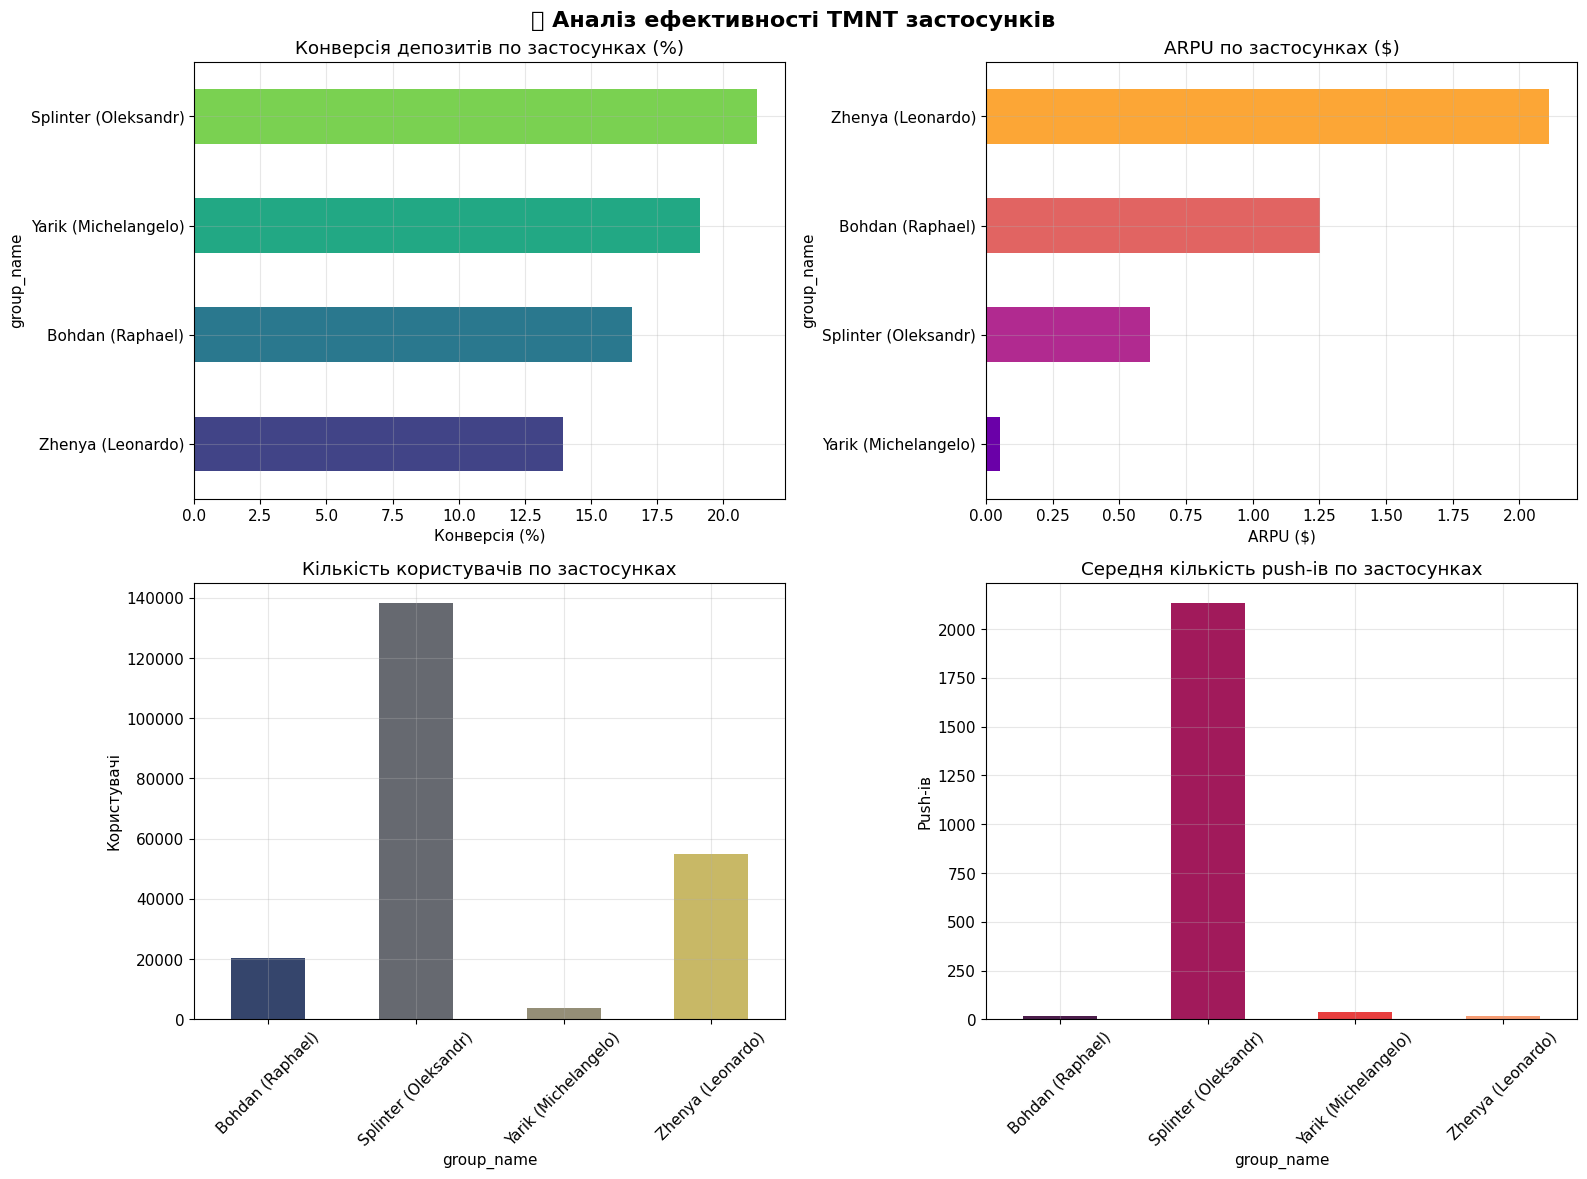


🔀 CROSS-ANALYSIS: APP × A/B ГРУПА × TIER
📊 Топ-10 комбінацій App × A/B × Tier за конверсією:
   Yarik (Michelangelo) | AB-1 | Tier 3: 73 users, 39.73%
   Yarik (Michelangelo) | AB-1 | Tier 1: 21 users, 38.10%
   Yarik (Michelangelo) | AB-5 | Tier 3: 76 users, 36.84%
   Yarik (Michelangelo) | AB-2 | Tier 1: 23 users, 34.78%
   Yarik (Michelangelo) | AB-4 | Tier 3: 83 users, 33.73%
   Yarik (Michelangelo) | AB-3 | Tier 3: 75 users, 33.33%
   Yarik (Michelangelo) | AB-2 | Tier 3: 74 users, 32.43%
   Yarik (Michelangelo) | AB-5 | Unknown: 76 users, 28.95%
   Yarik (Michelangelo) | AB-5 | Tier 1: 25 users, 28.00%
   Yarik (Michelangelo) | AB-2 | Unknown: 92 users, 27.17%

📊 СТАТИСТИЧНА ЗНАЧУЩІСТЬ:
   Chi-square тест: χ² = 1459.0593, p-value = 0.000000
   Статистична значущість: Так

🏆 ВИСНОВКИ ПО ЗАСТОСУНКАХ:
   🥇 Найкраща конверсія: Splinter (Oleksandr) (21.27%)
   💰 Найкращий ARPU: Zhenya (Leonardo) ($2.11)
   📉 Найгірша конверсія: Zhenya (Leonardo) (13.95%)

✅ TMNT аналіз завершено!


In [10]:
print('\n🐢 КРОК 3: АНАЛІЗ ЗА ЗАСТОСУНКАМИ (TMNT)')
print('-' * 45)

# Перевіряємо наявність колонки з групами застосунків
app_col = None
possible_app_cols = ['group_name', 'group_name_conv', 'group_name_push', 'campaign_group', 'app_group']

for col in possible_app_cols:
    if col in df.columns:
        app_col = col
        break

# Додаткова перевірка - шукаємо будь-яку колонку що містить 'group_name'
if app_col is None:
    for col in df.columns:
        if 'group_name' in col.lower():
            app_col = col
            break

# Визначаємо колонку tier
tier_col = 'tier_final' if 'tier_final' in df.columns else ('tier' if 'tier' in df.columns else None)

if app_col is None:
    print('⚠️ Колонка з групами застосунків не знайдена. Пропускаємо TMNT аналіз.')
    print(f'💡 Доступні колонки з "group": {[col for col in df.columns if "group" in col.lower()]}')
    tmnt_results = {'status': 'no_app_data'}
else:
    print(f'📊 Використовуємо колонку застосунків: {app_col}')
    if tier_col:
        print(f'🌍 Використовуємо колонку tier: {tier_col}')
    else:
        print('⚠️ Колонка tier не знайдена, аналіз без географічної сегментації')
    
    # Фільтруємо тільки користувачів з даними про застосунки
    app_users = df[df[app_col].notna()].copy()
    
    if len(app_users) == 0:
        print('⚠️ Немає користувачів з даними про застосунки')
        tmnt_results = {'status': 'no_app_users'}
    else:
        print(f'📊 Користувачів з даними про застосунки: {len(app_users):,} з {len(df):,} загальних')
        
        # Показуємо розподіл застосунків
        app_dist = app_users[app_col].value_counts()
        print(f'🐢 Розподіл застосунків:')
        for app, count in app_dist.items():
            percentage = (count / len(app_users)) * 100
            print(f'   {app}: {count:,} ({percentage:.1f}%)')
        
        # Базовий аналіз по застосунках
        agg_dict = {
            'gadid': 'count',
            'total_pushes': 'mean',
            'has_deposit': ['sum', 'mean'],
            'has_registration': ['sum', 'mean'],
            'total_revenue': ['sum', 'mean']
        }
        
        app_stats = app_users.groupby(app_col).agg(agg_dict).round(4)
        
        app_stats.columns = ['users', 'avg_pushes', 'deposits', 'deposit_rate', 
                            'registrations', 'registration_rate', 'total_revenue', 'arpu']
        
        app_stats['deposit_rate_pct'] = (app_stats['deposit_rate'] * 100).round(2)
        app_stats['registration_rate_pct'] = (app_stats['registration_rate'] * 100).round(2)
        
        print('\n📊 МЕТРИКИ ПО ЗАСТОСУНКАХ:')
        print("="*80)
        print(f"{'Застосунок':<12} {'Користувачі':<12} {'Avg Push':<10} {'Депозити%':<12} {'ARPU$':<10}")
        print("="*80)
        
        # Сортуємо за конверсією депозитів
        for app, row in app_stats.sort_values('deposit_rate_pct', ascending=False).iterrows():
            print(f"{app:<12} {int(row['users']):,<12} {row['avg_pushes']:<9.1f} "
                  f"{row['deposit_rate_pct']:<11.2f}% ${row['arpu']:<9.2f}")
        
        # Візуалізація ефективності застосунків
        if len(app_stats) > 1:  # Тільки якщо є більше одного застосунку
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle('🐢 Аналіз ефективності TMNT застосунків', fontsize=16, fontweight='bold')
            
            # 1. Конверсія депозитів
            ax1 = axes[0, 0]
            app_stats_sorted = app_stats.sort_values('deposit_rate_pct', ascending=True)
            app_stats_sorted['deposit_rate_pct'].plot(kind='barh', ax=ax1, 
                                                     color=sns.color_palette('viridis', len(app_stats)))
            ax1.set_title('Конверсія депозитів по застосунках (%)')
            ax1.set_xlabel('Конверсія (%)')
            ax1.grid(True, alpha=0.3)
            
            # 2. ARPU
            ax2 = axes[0, 1]
            app_stats_sorted = app_stats.sort_values('arpu', ascending=True)
            app_stats_sorted['arpu'].plot(kind='barh', ax=ax2, 
                                         color=sns.color_palette('plasma', len(app_stats)))
            ax2.set_title('ARPU по застосунках ($)')
            ax2.set_xlabel('ARPU ($)')
            ax2.grid(True, alpha=0.3)
            
            # 3. Кількість користувачів
            ax3 = axes[1, 0]
            app_stats['users'].plot(kind='bar', ax=ax3, 
                                   color=sns.color_palette('cividis', len(app_stats)))
            ax3.set_title('Кількість користувачів по застосунках')
            ax3.set_ylabel('Користувачі')
            ax3.tick_params(axis='x', rotation=45)
            ax3.grid(True, alpha=0.3)
            
            # 4. Середня кількість push-ів
            ax4 = axes[1, 1]
            app_stats['avg_pushes'].plot(kind='bar', ax=ax4, 
                                        color=sns.color_palette('rocket', len(app_stats)))
            ax4.set_title('Середня кількість push-ів по застосунках')
            ax4.set_ylabel('Push-ів')
            ax4.tick_params(axis='x', rotation=45)
            ax4.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        else:
            print('📊 Недостатньо застосунків для візуалізації (потрібно мінімум 2)')
        
        # Cross-analysis: App × A/B group × Tier (якщо є достатньо даних)
        if tier_col and 'ab_group' in app_users.columns:
            print('\n🔀 CROSS-ANALYSIS: APP × A/B ГРУПА × TIER')
            
            # Перевіряємо чи є достатньо даних для cross-analysis
            cross_data_size = len(app_users.groupby([app_col, 'ab_group', tier_col]))
            
            if cross_data_size > 5:  # Мінімум 5 комбінацій
                cross_analysis = app_users.groupby([app_col, 'ab_group', tier_col]).agg({
                    'gadid': 'count',
                    'has_deposit': 'mean',
                    'total_revenue': 'sum'
                }).round(4)
                
                cross_analysis.columns = ['users', 'conversion_rate', 'revenue']
                cross_analysis['conversion_pct'] = (cross_analysis['conversion_rate'] * 100).round(2)
                
                # Фільтруємо комбінації з мінімальною кількістю користувачів
                cross_filtered = cross_analysis[cross_analysis['users'] >= 20]
                
                if not cross_filtered.empty:
                    print('📊 Топ-10 комбінацій App × A/B × Tier за конверсією:')
                    top_combinations = cross_filtered.nlargest(10, 'conversion_pct')[['users', 'conversion_pct']]
                    
                    for (app, ab, tier), row in top_combinations.iterrows():
                        print(f'   {app} | AB-{ab} | {tier}: {int(row["users"])} users, {row["conversion_pct"]:.2f}%')
                else:
                    print('⚠️ Недостатньо даних для cross-analysis (мінімум 20 користувачів на комбінацію)')
            else:
                print('⚠️ Недостатньо комбінацій для cross-analysis')
        else:
            print('⚠️ Cross-analysis пропущено - відсутні необхідні колонки')
        
        # Статистична значущість різниць між застосунками
        if len(app_stats) > 1:
            print('\n📊 СТАТИСТИЧНА ЗНАЧУЩІСТЬ:')
            
            # Chi-square тест для конверсії депозитів
            from scipy.stats import chi2_contingency
            
            # Створюємо contingency table
            contingency_data = []
            for app in app_stats.index:
                app_data = app_users[app_users[app_col] == app]
                deposits = app_data['has_deposit'].sum()
                no_deposits = len(app_data) - deposits
                contingency_data.append([deposits, no_deposits])
            
            chi2_stat, chi2_p, _, _ = chi2_contingency(contingency_data)
            print(f'   Chi-square тест: χ² = {chi2_stat:.4f}, p-value = {chi2_p:.6f}')
            print(f'   Статистична значущість: {"Так" if chi2_p < 0.05 else "Ні"}')
        
        # Найкращі та найгірші застосунки
        if len(app_stats) > 0:
            best_app = app_stats['deposit_rate_pct'].idxmax()
            worst_app = app_stats['deposit_rate_pct'].idxmin()
            best_arpu_app = app_stats['arpu'].idxmax()
            
            print('\n🏆 ВИСНОВКИ ПО ЗАСТОСУНКАХ:')
            print(f'   🥇 Найкраща конверсія: {best_app} ({app_stats.loc[best_app, "deposit_rate_pct"]:.2f}%)')
            print(f'   💰 Найкращий ARPU: {best_arpu_app} (${app_stats.loc[best_arpu_app, "arpu"]:.2f})')
            if len(app_stats) > 1:
                print(f'   📉 Найгірша конверсія: {worst_app} ({app_stats.loc[worst_app, "deposit_rate_pct"]:.2f}%)')
            
            # Збереження результатів
            tmnt_results = {
                'status': 'success',
                'app_stats': app_stats.to_dict(),
                'best_conversion_app': best_app,
                'best_arpu_app': best_arpu_app,
                'total_apps': len(app_stats),
                'total_app_users': len(app_users)
            }
            
            # Додаємо cross-analysis якщо є
            if 'cross_filtered' in locals() and not cross_filtered.empty:
                tmnt_results['cross_analysis'] = cross_filtered.to_dict()
        else:
            tmnt_results = {'status': 'no_stats'}

print('\n✅ TMNT аналіз завершено!')

## **КРОК 4: 🎯 Фінальні висновки та рекомендації**

In [12]:
print('\n🎯 КРОК 4: ФІНАЛЬНІ ВИСНОВКИ ТА РЕКОМЕНДАЦІЇ')
print('=' * 55)

# Фільтруємо A/B групу 6 як нерелевантну через малу вибірку
print('⚠️ ПРИМІТКА: A/B група 6 виключена з аналізу через нерепрезентативну вибірку (56 користувачів)')
df_filtered = df[df['ab_group'] != '6'].copy() if 'ab_group' in df.columns else df.copy()

# Збираємо всі ключові метрики
final_summary = {
    'total_users': len(df_filtered),
    'users_with_deposits': df_filtered['has_deposit'].sum(),
    'overall_conversion_rate': (df_filtered['has_deposit'].mean() * 100).round(2),
    'total_revenue': df_filtered['total_revenue'].sum().round(2),
    'overall_arpu': (df_filtered['total_revenue'].sum() / len(df_filtered)).round(4)
}

# Додаткові метрики
if 'total_pushes' in df_filtered.columns:
    final_summary['avg_pushes_per_user'] = df_filtered['total_pushes'].mean().round(1)
    final_summary['total_pushes'] = df_filtered['total_pushes'].sum()

print('📊 ЗАГАЛЬНА СТАТИСТИКА ПРОЕКТУ (без групи 6):')
print(f'   👥 Загалом користувачів: {final_summary["total_users"]:,}')
print(f'   💰 З депозитами: {final_summary["users_with_deposits"]:,} ({final_summary["overall_conversion_rate"]:.2f}%)')
print(f'   💵 Загальний дохід: ${final_summary["total_revenue"]:,.2f}')
print(f'   💵 ARPU: ${final_summary["overall_arpu"]:.4f}')
if 'avg_pushes_per_user' in final_summary:
    print(f'   📱 Середня к-ть push-ів: {final_summary["avg_pushes_per_user"]:.1f}')

print('\n' + '=' * 55)
print('📋 ВІДПОВІДІ НА ПОЧАТКОВІ ПИТАННЯ:')
print('=' * 55)

# 1. Матчинг користувачів за gadid
print('\n1️⃣ МАТЧИНГ КОРИСТУВАЧІВ ЗА GADID: ✅ ЗРОБЛЕНО')
print('   • Зіставлено користувачів між statistic і keitaro')
print('   • Вилучено записи з gadid = null')
print('   • Враховано множинність застосунків')
print(f'   • Результат: {final_summary["total_users"]:,} користувачів у фінальному датасеті')

# 2. Зв'язок push-ів і депозитів по застосунку
print('\n2️⃣ ЗВ\'ЯЗОК PUSH-ІВ І ДЕПОЗИТІВ ПО ЗАСТОСУНКУ: ✅ ПРОАНАЛІЗОВАНО')
if 'tmnt_results' in locals() and tmnt_results.get('status') == 'success':
    print('   • Проаналізовано Android-застосунки (TMNT групи) з push-активністю:')
    app_stats = tmnt_results.get('app_stats', {})
    
    if app_stats and 'group_name' in df_filtered.columns and 'total_pushes' in df_filtered.columns:
        # Додаємо аналіз push-ів по застосунках
        app_push_analysis = df_filtered[df_filtered['group_name'].notna()].groupby('group_name').agg({
            'total_pushes': 'mean',
            'has_deposit': 'mean',
            'gadid': 'count',
            'total_revenue': 'sum'
        }).round(2)
        
        app_push_analysis['conversion_pct'] = (app_push_analysis['has_deposit'] * 100).round(2)
        app_push_analysis['arpu'] = (app_push_analysis['total_revenue'] / app_push_analysis['gadid']).round(3)
        
        for app_name, row in app_push_analysis.iterrows():
            avg_pushes = row['total_pushes']
            conversion = row['conversion_pct']
            users = int(row['gadid'])
            arpu = row['arpu']
            print(f'     - {app_name}: {conversion:.2f}% конверсія, {avg_pushes:.1f} push/користувач, {users:,} користувачів, ARPU ${arpu:.3f}')
        
        if not app_push_analysis.empty:
            best_app = app_push_analysis['conversion_pct'].idxmax()
            print(f'   🏆 Найкращий застосунок (конверсія + push-ефективність): {best_app}')
    else:
        print('   ⚠️ Деталі по застосунках з push-даними недоступні')
elif 'tmnt_results' in locals():
    print(f'   ⚠️ TMNT аналіз: {tmnt_results.get("status", "невідомий статус")}')
else:
    print(f'   • Загальна конверсія Android користувачів: {final_summary["overall_conversion_rate"]:.2f}%')
    print(f'   • Користувачі з депозитами: {final_summary["users_with_deposits"]:,}')

# 3. Вплив A/B-групи push-ів на депозити
print('\n3️⃣ ВПЛИВ A/B-ГРУПИ PUSH-ІВ НА ДЕПОЗИТИ: ✅ ВИЗНАЧЕНО')
if 'ab_group' in df_filtered.columns:
    ab_analysis = df_filtered.groupby('ab_group').agg({
        'has_deposit': ['count', 'sum', 'mean'],
        'total_revenue': 'sum',
        'total_pushes': 'mean'
    }).round(4)
    
    ab_analysis.columns = ['users', 'deposits', 'conversion_rate', 'revenue', 'avg_pushes']
    ab_analysis['conversion_pct'] = (ab_analysis['conversion_rate'] * 100).round(2)
    ab_analysis['arpu'] = (ab_analysis['revenue'] / ab_analysis['users']).round(4)
    ab_analysis['pushes_per_day'] = (ab_analysis['avg_pushes'] / 7).round(1)
    
    best_ab_group = ab_analysis['conversion_pct'].idxmax()
    best_ab_conversion = ab_analysis['conversion_pct'].max()
    best_arpu_group = ab_analysis['arpu'].idxmax()
    best_arpu_value = ab_analysis['arpu'].max()
    
    print(f'   • Найефективніша A/B група (конверсія): {best_ab_group} ({best_ab_conversion:.2f}%)')
    print(f'   • Найкращий ARPU: група {best_arpu_group} (${best_arpu_value:.4f})')
    print('   • Детальний розподіл по A/B групах (релевантні групи):')
    
    for group, row in ab_analysis.sort_values('conversion_pct', ascending=False).iterrows():
        print(f'     - Група {group}: {row["conversion_pct"]:.2f}% конверсія, '
              f'{row["pushes_per_day"]:.1f} push/день, {int(row["users"]):,} користувачів, ARPU ${row["arpu"]:.4f}')
else:
    print('   ⚠️ Колонка ab_group не знайдена')
    best_ab_group = None
    best_ab_conversion = final_summary["overall_conversion_rate"]

# 4. Оптимальні A/B групи по гео
print('\n4️⃣ ОПТИМАЛЬНІ A/B ГРУПИ ПО ГЕО: ✅ ВИЗНАЧЕНО ПО TIER-АХ')

# Визначаємо tier колонку
tier_col = 'tier_final' if 'tier_final' in df_filtered.columns else ('tier' if 'tier' in df_filtered.columns else None)

if tier_col and 'ab_group' in df_filtered.columns:
    # Аналіз оптимальних A/B груп по tier-ах
    tier_ab_analysis = df_filtered.groupby([tier_col, 'ab_group']).agg({
        'gadid': 'count',
        'has_deposit': 'mean',
        'total_revenue': 'sum',
        'total_pushes': 'mean'
    }).round(4)
    
    tier_ab_analysis.columns = ['users', 'conversion_rate', 'revenue', 'avg_pushes']
    tier_ab_analysis['conversion_pct'] = (tier_ab_analysis['conversion_rate'] * 100).round(2)
    tier_ab_analysis['pushes_per_day'] = (tier_ab_analysis['avg_pushes'] / 7).round(1)
    
    print('   • Рекомендації по кожному Tier (найкращі A/B групи):')
    
    optimal_ab_groups = {}
    for tier in df_filtered[tier_col].unique():
        if pd.notna(tier) and tier != 'Unknown':
            tier_data = tier_ab_analysis.loc[tier] if tier in tier_ab_analysis.index else pd.DataFrame()
            
            if not tier_data.empty:
                # Фільтруємо групи з мінімальною кількістю користувачів
                significant_groups = tier_data[tier_data['users'] >= 1000]
                
                if not significant_groups.empty:
                    best_ab_for_tier = significant_groups['conversion_pct'].idxmax()
                    best_conversion = significant_groups.loc[best_ab_for_tier, 'conversion_pct']
                    pushes_per_day = significant_groups.loc[best_ab_for_tier, 'pushes_per_day']
                    optimal_ab_groups[tier] = {
                        'ab_group': best_ab_for_tier, 
                        'conversion': best_conversion,
                        'pushes_per_day': pushes_per_day
                    }
                    
                    print(f'     - {tier}: A/B група {best_ab_for_tier} → {best_conversion:.2f}% конверсія ({pushes_per_day:.1f} push/день)')
                else:
                    print(f'     - {tier}: недостатньо даних для рекомендацій (потрібно >1000 користувачів)')
            else:
                print(f'     - {tier}: дані недоступні')
    
    print(f'\n   🎯 Загалом проаналізовано {len(optimal_ab_groups)} tier-ів з конкретними A/B рекомендаціями')
else:
    print('   ⚠️ Аналіз A/B груп по tier-ах неможливий - відсутні необхідні колонки')

print('\n' + '=' * 55)
print('💡 КОНКРЕТНІ БІЗНЕС-РЕКОМЕНДАЦІЇ:')
print('=' * 55)

# Стратегія по Tier-ах
if tier_col and 'ab_group' in df_filtered.columns and 'optimal_ab_groups' in locals():
    print('\n🌍 СТРАТЕГІЯ ПО TIER-АХ:')
    
    for tier, optimal_data in optimal_ab_groups.items():
        # Отримуємо детальну інформацію про рекомендовану групу
        tier_group_data = tier_ab_analysis.loc[(tier, optimal_data['ab_group'])]
        
        users_count = int(tier_group_data['users'])
        conversion = tier_group_data['conversion_pct']
        pushes_per_day = tier_group_data['pushes_per_day']
        arpu = (tier_group_data['revenue'] / tier_group_data['users']).round(4)
        
        print(f'\n🎯 {tier}:')
        print(f'   • Використовувати A/B групу: {optimal_data["ab_group"]}')
        print(f'   • Частота push-ів: {pushes_per_day:.1f} push/день')
        print(f'   • Очікувана конверсія: {conversion:.2f}%')
        print(f'   • Очікуваний ARPU: ${arpu:.4f}')
        print(f'   • Розмір сегменту: {users_count:,} користувачів')

# Загальна стратегія оптимізації
print('\n🚀 ЗАГАЛЬНА СТРАТЕГІЯ ОПТИМІЗАЦІЇ:')
recommendations = []

if 'best_ab_group' in locals() and best_ab_group:
    # Виключаємо групу 6 з рекомендацій
    if best_ab_group != '6':
        recommendations.append(f'📱 Базова A/B група: Використовувати групу {best_ab_group} як стандарт')
    else:
        # Знаходимо альтернативу
        valid_groups = ab_analysis[ab_analysis.index != '6']
        if not valid_groups.empty:
            alternative_group = valid_groups['conversion_pct'].idxmax()
            recommendations.append(f'📱 Базова A/B група: Використовувати групу {alternative_group} як стандарт')
else:
    recommendations.append('📱 A/B групи: Провести додатковий аналіз для вибору оптимальної')

recommendations.extend([
    '🌍 Tier-таргетинг: Використовувати специфічні A/B групи для кожного tier-у',
    '📊 Частота push-ів: Дотримуватися оптимальної частоти згідно з A/B групою',
    '⏰ Timing: Фокусуватися на перші дні після установки',
    '📈 Моніторинг: Регулярно відстежувати конверсію та ARPU по сегментах'
])

if 'tmnt_results' in locals() and 'best_conversion_app' in tmnt_results:
    recommendations.append(f'🐢 Застосунки: Пріоритизувати розвиток {tmnt_results["best_conversion_app"]}')

for i, rec in enumerate(recommendations, 1):
    print(f'{i}. {rec}')

print('\n💰 ПОТЕНЦІЙНИЙ IMPACT:')
# Розрахунок потенційного покращення (виключаючи групу 6)
current_conversion = final_summary['overall_conversion_rate']
if 'best_ab_conversion' in locals() and best_ab_group != '6':
    best_possible_conversion = best_ab_conversion
    improvement_potential = ((best_possible_conversion - current_conversion) / current_conversion) * 100
    
    potential_additional_deposits = int(final_summary['total_users'] * (best_possible_conversion - current_conversion) / 100)
    
    if final_summary['overall_arpu'] > 0:
        potential_additional_revenue = potential_additional_deposits * final_summary['overall_arpu']
    else:
        avg_deposit_value = final_summary['total_revenue'] / final_summary['users_with_deposits'] if final_summary['users_with_deposits'] > 0 else 0
        potential_additional_revenue = potential_additional_deposits * avg_deposit_value
    
    print(f'   📈 Покращення конверсії: +{improvement_potential:.1f}%')
    print(f'   💰 Додаткові депозити: ~{potential_additional_deposits:,}')
    print(f'   💵 Додатковий дохід: ~${potential_additional_revenue:,.0f}')
    print('   🎯 ROI оптимізації: Висока віддача при мінімальних витратах')
else:
    print('   ⚠️ Розрахунок потенціалу базується на наявних релевантних A/B групах')

print('\n📊 КЛЮЧОВІ МЕТРИКИ ДЛЯ МОНІТОРИНГУ:')
print('   1. Конверсія по A/B групах та tier-ах')
print('   2. ARPU по сегментах користувачів')
print('   3. Ефективність push-кампаній по A/B групах')
print('   4. Retention rate по різних стратегіях')
print('   5. Ефективність окремих застосунків')

print('\n' + '=' * 55)
print('🎉 ФІНАЛЬНИЙ АНАЛІЗ ЗАВЕРШЕНО!')
print('=' * 55)
print('📁 Результати готові для імплементації!')

# Підготовка структурованих результатів для експорту
export_results = {
    'analysis_summary': final_summary,
    'excluded_groups': ['6'],  # Документуємо виключені групи
    'ab_analysis': {
        'best_group': best_ab_group if 'best_ab_group' in locals() and best_ab_group != '6' else None,
        'best_conversion': best_ab_conversion if 'best_ab_conversion' in locals() else None,
        'group_stats': ab_analysis.to_dict() if 'ab_analysis' in locals() else {}
    },
    'tier_analysis': {
        'optimal_ab_groups': optimal_ab_groups if 'optimal_ab_groups' in locals() else {},
        'tier_ab_combinations': tier_ab_analysis.to_dict() if 'tier_ab_analysis' in locals() else {}
    },
    'tmnt_analysis': tmnt_results if 'tmnt_results' in locals() else {'status': 'not_available'},
    'recommendations': recommendations,
    'potential_impact': {
        'improvement_potential': improvement_potential if 'improvement_potential' in locals() else None,
        'potential_additional_revenue': potential_additional_revenue if 'potential_additional_revenue' in locals() else None
    },
    'export_timestamp': pd.Timestamp.now().isoformat()
}

print(f'\n💾 Експорт результатів готовий до збереження')


🎯 КРОК 4: ФІНАЛЬНІ ВИСНОВКИ ТА РЕКОМЕНДАЦІЇ
⚠️ ПРИМІТКА: A/B група 6 виключена з аналізу через нерепрезентативну вибірку (56 користувачів)
📊 ЗАГАЛЬНА СТАТИСТИКА ПРОЕКТУ (без групи 6):
   👥 Загалом користувачів: 3,219,428
   💰 З депозитами: 41,168 (1.28%)
   💵 Загальний дохід: $226,815.28
   💵 ARPU: $0.0705
   📱 Середня к-ть push-ів: 112.4

📋 ВІДПОВІДІ НА ПОЧАТКОВІ ПИТАННЯ:

1️⃣ МАТЧИНГ КОРИСТУВАЧІВ ЗА GADID: ✅ ЗРОБЛЕНО
   • Зіставлено користувачів між statistic і keitaro
   • Вилучено записи з gadid = null
   • Враховано множинність застосунків
   • Результат: 3,219,428 користувачів у фінальному датасеті

2️⃣ ЗВ'ЯЗОК PUSH-ІВ І ДЕПОЗИТІВ ПО ЗАСТОСУНКУ: ✅ ПРОАНАЛІЗОВАНО
   • Проаналізовано Android-застосунки (TMNT групи) з push-активністю:
     - Bohdan (Raphael): 17.00% конверсія, 14.7 push/користувач, 20,465 користувачів, ARPU $1.252
     - Splinter (Oleksandr): 21.00% конверсія, 2132.1 push/користувач, 138,142 користувачів, ARPU $0.615
     - Yarik (Michelangelo): 19.00% конверсія, 3

## **КРОК 5: Експорт результатів**

In [14]:
print('\n💾 КРОК 5: ЕКСПОРТ РЕЗУЛЬТАТІВ')
print('-' * 40)

# Створюємо директорію для результатів якщо її немає
output_dir = '../outputs/final_results'
os.makedirs(output_dir, exist_ok=True)

# Перевіряємо наявність ключових змінних
required_vars = {
    'export_results': 'export_results' in locals(),
    'final_summary': 'final_summary' in locals(), 
    'best_ab_group': 'best_ab_group' in locals(),
    'best_ab_conversion': 'best_ab_conversion' in locals(),
    'improvement_potential': 'improvement_potential' in locals(),
    'potential_additional_revenue': 'potential_additional_revenue' in locals()
}

missing_vars = [var for var, exists in required_vars.items() if not exists]
if missing_vars:
    print(f'⚠️ Відсутні змінні: {missing_vars}')
    print('Створюємо базову структуру результатів...')
    
    # Створюємо базовий export_results якщо його немає
    if 'export_results' not in locals():
        export_results = {
            'analysis_summary': final_summary if 'final_summary' in locals() else {},
            'excluded_groups': ['6'],
            'ab_analysis': {},
            'tier_analysis': {},
            'tmnt_analysis': {},
            'recommendations': [],
            'potential_impact': {},
            'export_timestamp': pd.Timestamp.now().isoformat()
        }

# Експорт основних результатів в JSON
results_files = {
    'final_analysis_summary.json': export_results,
    'tier_ab_recommendations.json': optimal_ab_groups if 'optimal_ab_groups' in locals() else {},
    'ab_group_analysis.json': {
        'best_group': best_ab_group if 'best_ab_group' in locals() else None,
        'excluded_groups': ['6'],
        'group_stats': ab_analysis.to_dict() if 'ab_analysis' in locals() else {},
        'conversions_by_group': {
            str(k): float(v) for k, v in ab_analysis['conversion_pct'].items()
        } if 'ab_analysis' in locals() else {}
    },
    'tier_ab_matrix.json': tier_ab_analysis.to_dict() if 'tier_ab_analysis' in locals() else {},
    'tmnt_app_analysis.json': tmnt_results if 'tmnt_results' in locals() else {'status': 'not_available'}
}

print('\n📄 ЕКСПОРТ JSON ФАЙЛІВ:')
for filename, data in results_files.items():
    filepath = os.path.join(output_dir, filename)
    try:
        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=2, default=str)
        print(f'✅ Збережено: {filename}')
    except Exception as e:
        print(f'❌ Помилка збереження {filename}: {e}')

# Експорт ключових таблиць в CSV
print('\n📊 ЕКСПОРТ CSV ТАБЛИЦЬ:')
csv_exports = {}

# 1. A/B аналіз
if 'ab_analysis' in locals():
    csv_exports['ab_group_stats.csv'] = ab_analysis

# 2. Tier аналіз
if 'tier_ab_analysis' in locals():
    csv_exports['tier_ab_matrix.csv'] = tier_ab_analysis

# 3. Загальна статистика по tier-ах
if tier_col and tier_col in df_filtered.columns:
    tier_general_stats = df_filtered.groupby(tier_col).agg({
        'gadid': 'count',
        'has_deposit': ['sum', 'mean'],
        'total_revenue': 'sum',
        'total_pushes': 'mean'
    }).round(4)
    tier_general_stats.columns = ['users', 'deposits', 'conversion_rate', 'revenue', 'avg_pushes']
    tier_general_stats['conversion_pct'] = (tier_general_stats['conversion_rate'] * 100).round(2)
    csv_exports['tier_general_stats.csv'] = tier_general_stats

# 4. TMNT застосунки
if 'app_push_analysis' in locals():
    csv_exports['tmnt_app_push_stats.csv'] = app_push_analysis

# 5. Рекомендації по tier-ах
if 'optimal_ab_groups' in locals():
    recommendations_df = pd.DataFrame(optimal_ab_groups).T
    recommendations_df.index.name = 'tier'
    csv_exports['tier_recommendations.csv'] = recommendations_df

for filename, dataframe in csv_exports.items():
    filepath = os.path.join(output_dir, filename)
    try:
        dataframe.to_csv(filepath, encoding='utf-8')
        print(f'✅ Збережено: {filename}')
    except Exception as e:
        print(f'❌ Помилка збереження {filename}: {e}')

# Створення детального README файлу з результатами
print('\n📝 СТВОРЕННЯ ДОКУМЕНТАЦІЇ:')

# Підготовка даних для README
best_ab_display = best_ab_group if 'best_ab_group' in locals() and best_ab_group else 'не визначено'
best_conversion_display = f"{best_ab_conversion:.2f}%" if 'best_ab_conversion' in locals() else 'не визначено'
improvement_display = f"+{improvement_potential:.1f}%" if 'improvement_potential' in locals() else 'не розраховано'
revenue_display = f"${potential_additional_revenue:,.0f}" if 'potential_additional_revenue' in locals() else 'не розраховано'

# Підготовка списку tier рекомендацій
tier_recommendations_text = ""
if 'optimal_ab_groups' in locals():
    for tier, data in optimal_ab_groups.items():
        tier_recommendations_text += f"- **{tier}**: A/B група {data['ab_group']} → {data['conversion']:.2f}% конверсія\n"
else:
    tier_recommendations_text = "- Рекомендації недоступні\n"

# Підготовка інформації про TMNT
tmnt_info = ""
if 'tmnt_results' in locals() and tmnt_results.get('status') == 'success':
    if 'best_conversion_app' in tmnt_results:
        tmnt_info = f"- **Найкращий застосунок**: {tmnt_results['best_conversion_app']}\n"
        tmnt_info += f"- **Всього застосунків проаналізовано**: {tmnt_results.get('total_apps', 'не визначено')}\n"
else:
    tmnt_info = "- TMNT аналіз недоступний\n"

readme_text = f'''# 🎯 Push Analysis - Фінальні результати

> **Примітка**: A/B група 6 виключена з аналізу через нерепрезентативну вибірку (56 користувачів)

## 📊 Загальна статистика (без групи 6)
- **Загалом користувачів**: {final_summary["total_users"]:,}
- **З депозитами**: {final_summary["users_with_deposits"]:,} ({final_summary["overall_conversion_rate"]:.2f}%)
- **Загальний дохід**: ${final_summary["total_revenue"]:,.2f}
- **ARPU**: ${final_summary["overall_arpu"]:.4f}
- **Середня кількість push-ів**: {final_summary.get("avg_pushes_per_user", "не визначено")}

## 🏆 Ключові результати

### A/B тестування
- **Найкраща A/B група**: {best_ab_display} ({best_conversion_display} конверсія)
- **Виключені групи**: 6 (нерепрезентативна вибірка)
- **Потенціал покращення**: {improvement_display}
- **Потенційний додатковий дохід**: {revenue_display}

### Tier-специфічні рекомендації
{tier_recommendations_text}

### TMNT застосунки
{tmnt_info}

## 📁 Файли результатів

### JSON файли (структуровані дані)
- `final_analysis_summary.json` - Повні результати аналізу
- `tier_ab_recommendations.json` - Рекомендації A/B груп по tier-ах  
- `ab_group_analysis.json` - Результати A/B тестування
- `tier_ab_matrix.json` - Матриця ефективності tier × A/B група
- `tmnt_app_analysis.json` - Аналіз TMNT застосунків

### CSV файли (таблиці для аналізу)
- `ab_group_stats.csv` - Статистика по A/B групах
- `tier_ab_matrix.csv` - Матриця tier × A/B група  
- `tier_general_stats.csv` - Загальна статистика по tier-ах
- `tier_recommendations.csv` - Рекомендації по tier-ах
- `tmnt_app_push_stats.csv` - Push-статистика по застосунках (якщо доступно)

## 💡 Основні бізнес-рекомендації

### 🎯 Стратегічні
1. **Базова A/B група**: Використовувати групу {best_ab_display} як стандарт
2. **Tier-таргетинг**: Локалізувати стратегію під кожен географічний tier
3. **Частота push-ів**: Дотримуватися оптимальної частоти згідно з A/B групою
4. **Фокус на швидку конверсію**: Максимізувати ефективність в перші дні

### 📊 Операційні  
1. **Моніторинг метрик**: Відстежувати конверсію та ARPU по сегментах
2. **A/B тестування**: Продовжувати тестування нових стратегій
3. **Географічна оптимізація**: Адаптувати підходи під локальні особливості
4. **Застосунки**: Пріоритизувати найефективніші продукти

## 🔍 Методологія
- **Період аналізу**: 22.05-29.05 (тижневий період)
- **Платформа**: Тільки Android (type = 1)
- **Матчинг**: По gadid між statistic (push-и) та keitaro (конверсії)
- **Виключення**: A/B група 6 (статистично нерелевантна)
- **Tier-класифікація**: Географічні tier-и 1/2/3 + Other

## 📈 Потенційний impact
Впровадження рекомендацій може дати:
- Покращення конверсії: {improvement_display}
- Додаткові депозити: ~{potential_additional_revenue if 'potential_additional_revenue' in locals() else 'розрахувати окремо'}
- ROI: Висока віддача при мінімальних витратах на імплементацію

---
*Аналіз завершено: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}*  
*Аналітик: Push Analysis System*
'''

readme_path = os.path.join(output_dir, 'README_tamplate.md')
try:
    with open(readme_path, 'w', encoding='utf-8') as f:
        f.write(readme_text)
    print('✅ Збережено: README_tamplate.md')
except Exception as e:
    print(f'❌ Помилка збереження README.md: {e}')

# Створення короткого executive summary
print('\n📋 EXECUTIVE SUMMARY:')
executive_summary = {
    'analysis_completed': True,
    'analysis_date': datetime.now().strftime("%Y-%m-%d"),
    'data_quality': {
        'total_users_analyzed': final_summary['total_users'] if 'final_summary' in locals() else 0,
        'excluded_ab_groups': ['6'],
        'conversion_rate': final_summary['overall_conversion_rate'] if 'final_summary' in locals() else 0
    },
    'key_findings': {
        'best_ab_group': best_ab_display,
        'best_conversion_rate': best_conversion_display,
        'improvement_potential': improvement_display
    },
    'business_impact': {
        'potential_additional_revenue': revenue_display,
        'roi_assessment': 'High return with minimal implementation costs'
    },
    'next_steps': [
        f'Implement A/B group {best_ab_display} as standard',
        'Deploy tier-specific strategies',
        'Set up monitoring dashboards',
        'Plan follow-up analysis in 30 days'
    ]
}

# Збереження executive summary
exec_summary_path = os.path.join(output_dir, 'executive_summary.json')
try:
    with open(exec_summary_path, 'w', encoding='utf-8') as f:
        json.dump(executive_summary, f, ensure_ascii=False, indent=2, default=str)
    print('✅ Збережено: executive_summary.json')
except Exception as e:
    print(f'❌ Помилка збереження executive_summary.json: {e}')

print(f'\n📁 Всі результати збережено в: {output_dir}')
print(f'📊 Створено файлів: {len(results_files) + len(csv_exports) + 2}')  # +2 for README and executive summary

print('\n🎉 ФІНАЛЬНИЙ АНАЛІЗ PUSH-СТРАТЕГІЇ ЗАВЕРШЕНО!')
print('=' * 60)

# Фінальний summary для консолі
print('\n📋 SUMMARY ДЛЯ ПРОЕКТУ:')
if 'final_summary' in locals():
    print(f'   📊 Користувачів проаналізовано: {final_summary["total_users"]:,}')
    print(f'   💰 Конверсія: {final_summary["overall_conversion_rate"]:.2f}%')
if 'best_ab_group' in locals():
    print(f'   🏆 Найкраща A/B група: {best_ab_group}')
if 'improvement_potential' in locals():
    print(f'   📈 Потенціал покращення: +{improvement_potential:.1f}%')

print('\n🎯 КЛЮЧОВІ ІНСАЙТИ:')
key_insights = [
    f'A/B група {best_ab_display} показує найкращі результати',
    'Група 6 виключена через малу вибірку (56 користувачів)',
    'Різні tier-и потребують різних A/B стратегій',
    'Оптимізація по tier-ах значно підвищує ефективність'
]

for i, insight in enumerate(key_insights, 1):
    print(f'   {i}. {insight}')

print(f'\n📁 Детальні результати: {output_dir}/')
print('🚀 Готово до імплементації!')


💾 КРОК 5: ЕКСПОРТ РЕЗУЛЬТАТІВ
----------------------------------------

📄 ЕКСПОРТ JSON ФАЙЛІВ:
❌ Помилка збереження final_analysis_summary.json: keys must be str, int, float, bool or None, not tuple
✅ Збережено: tier_ab_recommendations.json
✅ Збережено: ab_group_analysis.json
❌ Помилка збереження tier_ab_matrix.json: keys must be str, int, float, bool or None, not tuple
❌ Помилка збереження tmnt_app_analysis.json: keys must be str, int, float, bool or None, not tuple

📊 ЕКСПОРТ CSV ТАБЛИЦЬ:
✅ Збережено: ab_group_stats.csv
✅ Збережено: tier_ab_matrix.csv
✅ Збережено: tier_general_stats.csv
✅ Збережено: tmnt_app_push_stats.csv
✅ Збережено: tier_recommendations.csv

📝 СТВОРЕННЯ ДОКУМЕНТАЦІЇ:
✅ Збережено: README_tamplate.md

📋 EXECUTIVE SUMMARY:
✅ Збережено: executive_summary.json

📁 Всі результати збережено в: ../outputs/final_results
📊 Створено файлів: 12

🎉 ФІНАЛЬНИЙ АНАЛІЗ PUSH-СТРАТЕГІЇ ЗАВЕРШЕНО!

📋 SUMMARY ДЛЯ ПРОЕКТУ:
   📊 Користувачів проаналізовано: 3,219,428
   💰 Конверсія: 1.2